<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [148]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [149]:
##### Your Code Here #####
df = pd.read_csv('data/job_listings.csv', encoding='utf-8')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [150]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
#     tokens = re.sub(r'[^a-zA-Z ^0-9]|/|<div>|</div>|<br/>|<ul>|<li>|<p>|</p>|</ul>|<n>|</n>|^\'b\"|\\\\n|</li>|/', '', text)
    tokens = re.sub(r'<div>|</div>|<br/>|<ul>|<li>|<p>|</p>|</ul>|<n>|</n>|^\'b\"|\\\\n|</li>|/', '', text)
    tokens = re.sub(r'[^a-zA-Z ^0-9]|/', ' ', tokens)
    tokens = tokens.lower().split()
    
    return tokens

def clean_html(text):
    text = re.sub(r'<div>|</div>|<br/>|<ul>|<li>|<p>|</p>|</ul>|<n>|</n>|^\'b\"|\\\\n|</li>|/', '', text)
    text = re.sub(r'[^a-zA-Z ^0-9]|/', ' ', text)
    return text

# df['description'] = df['description'].apply(lambda x: re.sub(r'<.*?>', ' ', x)).str.lower().str.split()
df['tokens'] = df['description'].apply(clean_html)
df.head()

,Unnamed: 0,description,title,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,b Job Requirements nConceptual understanding ...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,b Job Description n nAs a Data Scientist 1 yo...
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b As a Data Scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,b div class jobsearch JobMetadataHeader icl ...
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b Location USA xe2 x80 x93 multiple location...


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [151]:
##### Your Code Here #####
import spacy

nlp = spacy.load("en_core_web_sm")
# doc = nlp(df['description'])
# print([token.lemma_ for token in doc if not token.is_stop])
# df['tokens'] = df['description'].

In [152]:
df.head()

,Unnamed: 0,description,title,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,b Job Requirements nConceptual understanding ...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,b Job Description n nAs a Data Scientist 1 yo...
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b As a Data Scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,b div class jobsearch JobMetadataHeader icl ...
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b Location USA xe2 x80 x93 multiple location...


In [153]:
# alltokens = df['tokens'].str.join(" ").tolist()
# alltokens.head()

In [184]:
##### Your Code Here #####
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
STOPWORDS = nlp.Defaults.stop_words.union(['li', 'div', 'br', 'ul', 'x99s', 'xe2', 'x80'])
vect = CountVectorizer(stop_words=STOPWORDS)

vect.fit(df['description'])
dtm = vect.transform(df['description'])


C:\Users\Cooper\Anaconda3\envs\Mike\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [185]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()
dtmT = dtm.T
dtmT['totals'] = dtm.apply(lambda x: sum(x))
dtmT

,0,1,2,3,4,5,6,7,8,9,...,417,418,419,420,421,422,423,424,425,totals
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,52
02115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
06366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [186]:
dtmT.head()

,0,1,2,3,4,5,6,7,8,9,...,417,418,419,420,421,422,423,424,425,totals
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,52
02115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [187]:
topten = list(dtmT.sort_values(by='totals', ascending=False).head(25).index)
toptentotal = list(dtmT.sort_values(by='totals', ascending=False).head(25).totals)


## 4) Visualize the most common word counts

<BarContainer object of 25 artists>

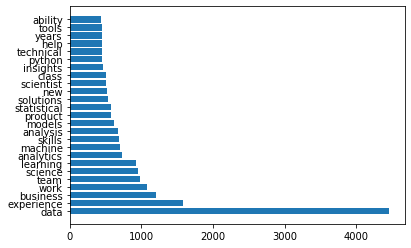

In [188]:
import matplotlib.pyplot as plt
plt.barh(topten, toptentotal)

In [189]:
##### Your Code Here #####

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [190]:
##### Your Code Here #####
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

dtm = tfidf.fit_transform(df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,00,000,02115,03,0356,04,057,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095122,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [191]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [192]:
# Nonsense job description
ideal = ["This job posting is for an ML engineer with many talents and interests. The ideal candidate would have a background in media, with interest in one or more of literature, politics, economics, and philosophy. This position will require you to combine investigative analysis with machine learning engineeering to provide insights on thought trends in social media. These insights would be used to predict demand for 21-century information products and enhance human freedoma and wellbeing."]
new = tfidf.transform(ideal)
nn.kneighbors(new.todense())

(array([[1.35135518, 1.35135518, 1.35606944, 1.35994467, 1.36373326]]),
 array([[ 15, 171, 298, 332, 419]], dtype=int64))

In [195]:
df.description[15]

'b\'<div><p>The Atlantic is seeking a Data Scientist to help lead research and analysis initiatives and support ongoing delivery of key insights to drive business growth and overall impact. The role will work closely with partners in Consumer Revenue, Advertising, Editorial, and Product to understand performance, identify and predict opportunities for improvement, and develop plans of action to maximize revenue, audience growth, and editorial engagement.</p>\\n<p>This is a great opportunity to be part of a growing team and help shape the way we develop, deploy, and operate production quality analytics systems and processes\\xe2\\x80\\x94and have an impact on how The Atlantic uses data in the years to come.</p>\\n<p><b>Responsibilities:</b></p>\\n<ul><li>Lead research projects from hypothesis formation to delivering findings and recommendations to stakeholders</li>\\n<li>Use supervised and unsupervised machine learning techniques to make predictions and categorize</li>\\n<li>Design, exe

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 